In [22]:
import SimpleITK as sitk
import matplotlib.pyplot as plt
from scipy.ndimage import zoom
import pandas as pd
import numpy as np
import copy
import math

# Ensure all rows and columns are printed
pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns

In [2]:
mouse_img = sitk.ReadImage("/Users/jessi/Downloads/17980_04_RARE.nii")
mouse_labels = sitk.ReadImage("/Users/jessi/Downloads/17980_04_RARE_labels_DSURQE.nii")
mouse_gm = sitk.ReadImage("/Users/jessi/Downloads/17980_04_RARE_labels_GMWM.nii")

human_img_un_proc = sitk.ReadImage("../2426850.nii")
human_atlas = sitk.ReadImage("./mni_icbm152_nlin_sym_09a/mni_icbm152_gm_tal_nlin_sym_09a.nii")

for (name, img) in [("mouse gmwm", mouse_gm), ("human img unproc", human_img_un_proc), ("human atlas", human_atlas)]:
    print(name + ":")
    print("Size:", img.GetSize())
    print("Spacing:", img.GetSpacing())
    print("Origin:", img.GetOrigin())
    print("Direction:", img.GetDirection())
    print()



mouse gmwm:
Size: (192, 256, 128)
Spacing: (0.07000000029802322, 0.07000000029802322, 0.07000000029802322)
Origin: (-6.265103816986084, -5.9957427978515625, 2.6782522201538086)
Direction: (1.0, 0.0, 0.0, 0.0, 0.9899924943294942, -0.14112002399116275, 0.0, -0.14112002399116275, -0.9899924943294942)

human img unproc:
Size: (182, 218, 182)
Spacing: (1.0, 1.0, 1.0)
Origin: (-90.0, 126.0, -72.0)
Direction: (1.0, 0.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0, 1.0)

human atlas:
Size: (197, 233, 189)
Spacing: (1.0, 1.0, 1.0)
Origin: (98.0, 134.0, -72.0)
Direction: (-1.0, 0.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0, 1.0)



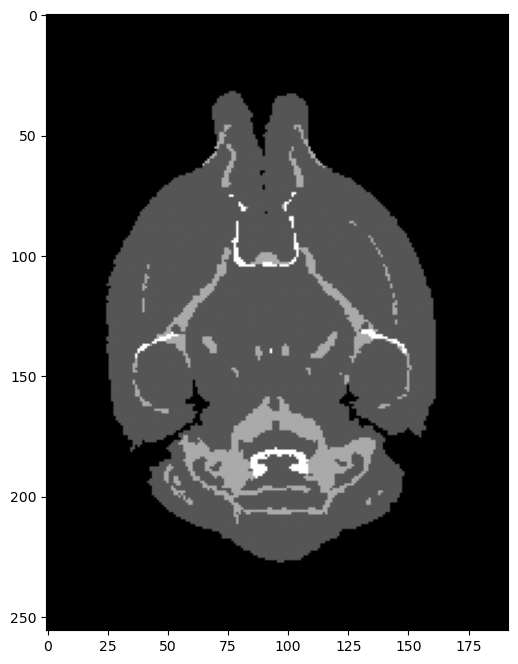

In [7]:
slice_idx = 70
plt.figure(figsize=(8, 8))
plt.imshow(sitk.GetArrayFromImage(mouse_gm)[slice_idx, :, :], cmap="gray", alpha=1.0)
#plt.imshow(sitk.GetArrayFromImage(mouse_labels)[slice_idx, :, :], cmap="jet", alpha=0.1)
plt.show()

In [ ]:
print("unique values in gmwm seg:", np.unique(sitk.GetArrayFromImage(mouse_gm)))
# I assume it's background, GM, WM, unlabeled?
#   => no there isn't a one-to-one correspondance between the G/W label and the segmnetation :/

unique values in gmwm seg: [0. 1. 2. 3.]


Relabel the GM/WM probs to discrete values (0 - background, 1 - GM, 2 - WM, 3 - CSF)

In [ ]:
human_gm = sitk.ReadImage("./mni_icbm152_nlin_sym_09a/mni_icbm152_gm_tal_nlin_sym_09a.nii")
human_wm = sitk.ReadImage("./mni_icbm152_nlin_sym_09a/mni_icbm152_wm_tal_nlin_sym_09a.nii")

In [32]:
# Q1 - are there cases where both are > 0.5
human_gm_arr = sitk.GetArrayFromImage(human_gm)
human_wm_arr = sitk.GetArrayFromImage(human_wm)

human_gm_disc = human_gm_arr >= 0.5
human_wm_disc = human_wm_arr >= 0.5
print("when are both >= 0.5:", np.sum(human_gm_disc & human_wm_disc))
print("num unlabeled/csf?", np.sum(~human_gm_disc & ~human_wm_disc & ~((human_gm_arr == 0) & (human_wm_arr == 0))))
print("background", np.sum((human_gm_arr == 0) & (human_wm_arr == 0)))
print("num gm:", np.sum(human_gm_disc))
print("num wm:", np.sum(human_wm_disc))

when are both >= 0.5: 2
num unlabeled/csf? 433457
background 6526012
num gm: 1082197
num wm: 633625


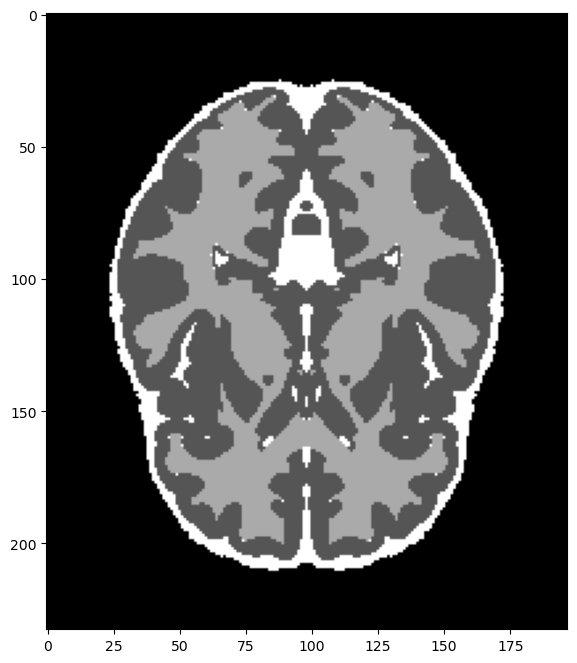

In [26]:
# test 1 - relabled with thresh 0.5 (even tho wayyyy to much CSF)

# all unlabled are 3 - csf
rl_thresh_p5 = np.ones(human_gm_arr.shape)*3

# map gm to 1
rl_thresh_p5[human_gm_arr >= 0.5] = 1
# map wm to 2 (overwrite the 2 redudant)
rl_thresh_p5[human_wm_arr >= 0.5] = 2
# map backgound to 0
rl_thresh_p5[(human_wm_arr == 0) & (human_gm_arr == 0)] = 0


slice_idx = 70
plt.figure(figsize=(8, 8))
plt.imshow(rl_thresh_p5[slice_idx, :, :], cmap="gray", alpha=1.0)
plt.show()

Register the Atlas to the each img with ANTs

In [35]:
human_atlas_mri = sitk.ReadImage("./mni_icbm152_nlin_sym_09a/mni_icbm152_t1_tal_nlin_sym_09a.nii")